# pycbf - Basic example

This notebook roughly simulates channel data and beamforms it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from pycbf import gpu, cpu
from scipy.signal import hilbert
from tqdm.notebook import tqdm

## Generating channel data

In [2]:
# channel data parameters
fc = 5E6        # centerfrequency of plane wave excitation [Hz]
fs =  6 * fc    # sampling frequency [Hz]
c = 1540        # speed of sound [m/s]
lam = c/fc      # wavelength [m]

nele = 64       # number of elements in probe
dele = lam      # probe spacing [m]

# locations of elements
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele, indexing='ij')
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# reconstruction grid
xgrid = dele*(np.arange(0, nele, 1/2) - (nele-1)/2)
ygrid = 0
zgrid = np.arange(1*lam, nele*dele, lam/8)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
grid = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

ex_grid = 1E3*np.array([xgrid[0], xgrid[-1], zgrid[-1], zgrid[0]])

## Calculate the full synthetic aperture using a point-like assumption

In [3]:
# location of point scatterer
rng = np.random.default_rng(0)

Np = 300
points = 1E-3*np.array([rng.uniform(-2.5, 2.5, Np), np.zeros(Np), rng.uniform(7.5, 12.5, Np)]).T
# pointa = np.array([[nele*dele/8, 0, nele*dele/4]])
# pointb = np.array([[-nele*dele/7, 0, nele*dele/3]])
# pointc = np.array([[0, 0, 2*nele*dele/7]])

rf = 0
for point in tqdm(points, total=len(points)):
    # time delays between each element and the point
    tau = np.linalg.norm(eles - point, axis=-1)/c

    # generate all (realtive) time points for each pulse
    tmax = 2*np.sqrt((dele * (nele-1))**2 + (nele*dele)**2)/c
    t = np.arange(0, tmax, 1/fs)

    # calculate all delay tabs
    T = t[None,None,:] - (tau[:,None,None] + tau[None,:,None])

    # make rf data from tabs
    rf += sig.gausspulse(t=T, fc=fc, bw=0.75)

# rf += np.ptp(rf)*rng.normal(0, 0.01, rf.shape)

  0%|          | 0/300 [00:00<?, ?it/s]

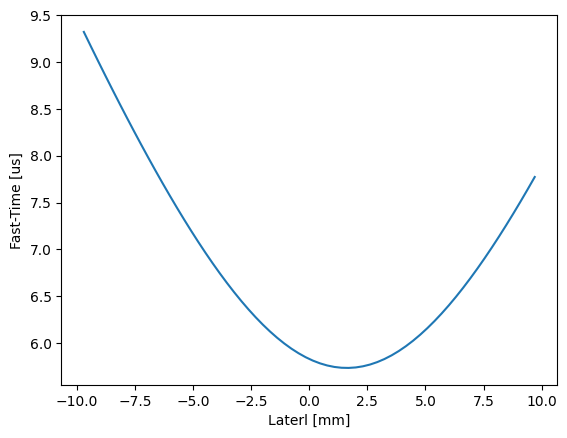

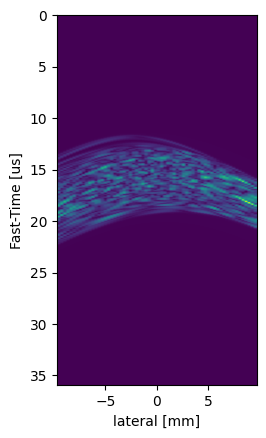

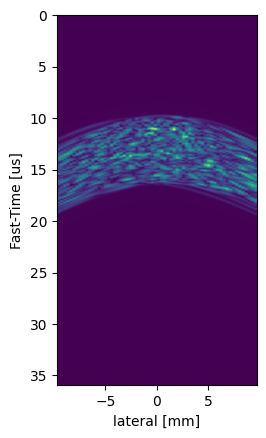

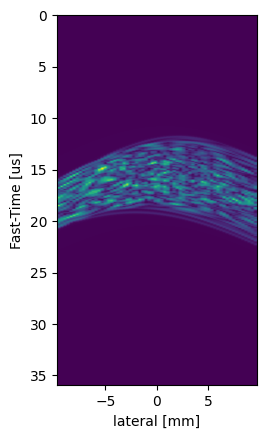

In [4]:
# plot delay tabs
plt.figure()
plt.plot(1E3*xele, 1E6*tau.flatten())
plt.xlabel("Laterl [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

env = np.abs(sig.hilbert(rf, axis=-1))
plt.figure()
plt.imshow(env[0,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[nele//2,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[-1,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

## Calculate delay tabs and apodizations

In [5]:
dXvec = grid[None,:,:] - eles[:,None,:]
fnum = 1
tautxrx = np.linalg.norm(dXvec, axis=-1)/c
apodrect = np.abs(dXvec[:,:,0]) - dXvec[:,:,2]/(2*fnum) < 0

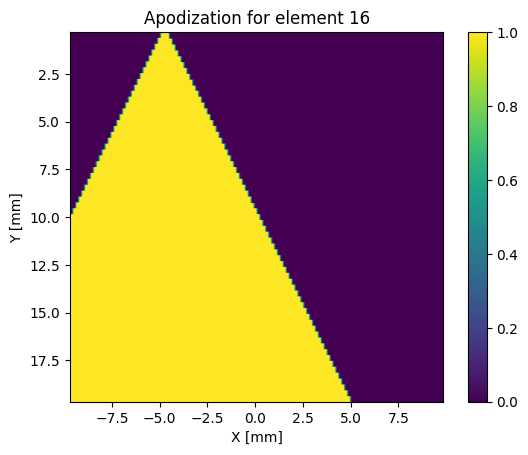

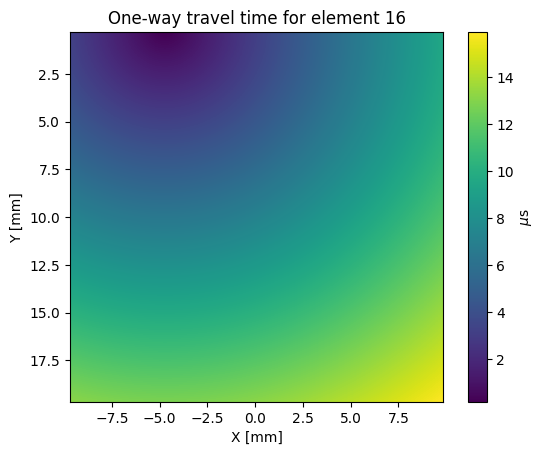

In [6]:
plt.figure()
plt.imshow(apodrect[16].reshape(Xgrid.shape[0], Xgrid.shape[-1]).T, extent=ex_grid)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("Apodization for element 16")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(
    1E6*tautxrx[16].reshape(Xgrid.shape[0], Xgrid.shape[-1]).T, 
    extent=ex_grid
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("One-way travel time for element 16")
plt.colorbar(label='$\\mu$s')
plt.show()

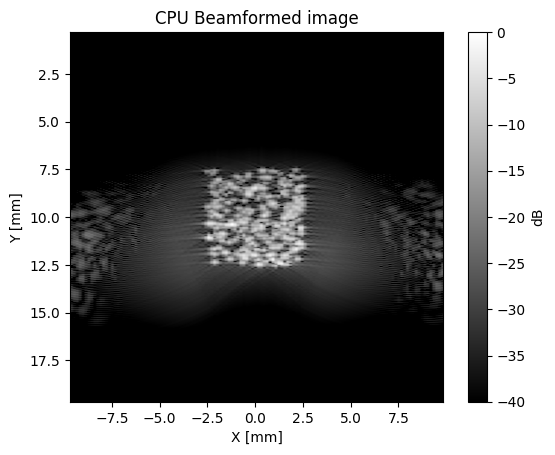

In [7]:
# current gold standard
bmfrm_cpu = cpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp = {"kind":"cubic"}
)

im_cpu = bmfrm_cpu(rf).reshape(Xgrid.shape).T.squeeze()
env_cpu = np.abs(hilbert(im_cpu, axis=0))
logged = 20*np.log10(env_cpu/np.max(env_cpu))

plt.figure()
plt.imshow(
    logged,
    extent=ex_grid,
    cmap='grey',
    vmin=-40, vmax=0
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("CPU Beamformed image")
plt.colorbar(label='dB')
plt.show()

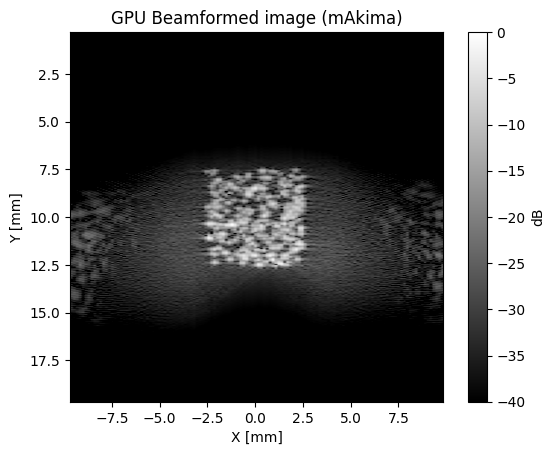

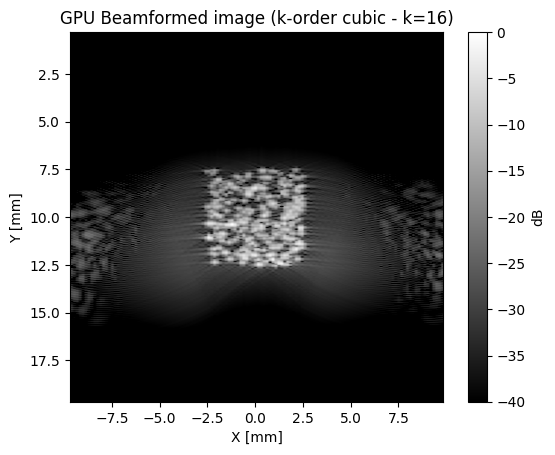

In [8]:
# GPU beamformer with Akima interpolation
bmfrm_gpu = gpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"makima"}
)

im_gpu = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
env_gpu = np.abs(hilbert(im_gpu, axis=0))
logged = 20*np.log10(env_gpu/np.max(env_gpu))

plt.figure()
plt.imshow(
    logged,
    extent=ex_grid,
    cmap='grey',
    vmin=-40, vmax=0
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("GPU Beamformed image (mAkima)")
plt.colorbar(label='dB')
plt.show()


# GPU beamformer with korder cubic interpolation
bmfrm_gpu = gpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"korder_cubic", "k":16}
)

im_gpu = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
env_gpu = np.abs(hilbert(im_gpu, axis=0))
logged = 20*np.log10(env_gpu/np.max(env_gpu))

plt.figure()
plt.imshow(
    logged,
    extent=ex_grid,
    cmap='grey',
    vmin=-40, vmax=0
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("GPU Beamformed image (k-order cubic - k=16)")
plt.colorbar(label='dB')
plt.show()

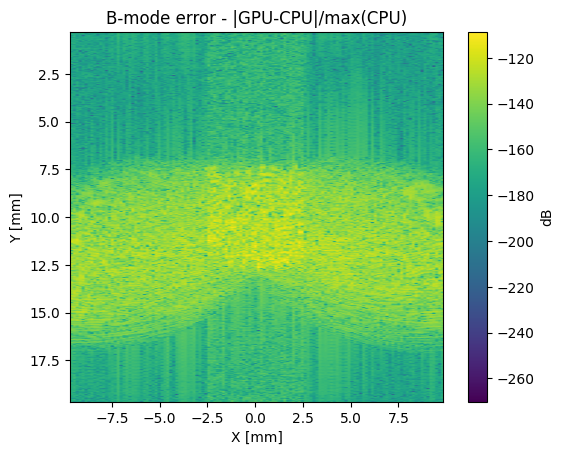

In [9]:
err_norm = np.abs(env_gpu-env_cpu)/np.max(env_cpu)

plt.figure()
plt.imshow(20*np.log10(err_norm),
    extent=ex_grid)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.colorbar(label='dB')
plt.title("B-mode error - |GPU-CPU|/max(CPU)")
plt.show()

In [10]:
# beamform using GPU-based nearest neighbor interpolation
bmfrm_cpu = cpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"nearest"}
)
im_cpu_nearest = bmfrm_cpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_cpu

# beamform using GPU-based nearest neighbor interpolation
bmfrm_cpu = cpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"nearest", "usf":8}
)
im_cpu_nearusf08 = bmfrm_cpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_cpu

# beamform using GPU-based nearest neighbor interpolation
bmfrm_cpu = cpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"nearest", "usf":64}
)
im_cpu_nearusf64 = bmfrm_cpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_cpu

# beamform using GPU-based nearest neighbor interpolation
bmfrm_gpu = gpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"nearest"}
)
im_gpu_nearest = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_gpu

# beamform using GPU-based linear interpolation
bmfrm_gpu = gpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"linear"}
)
im_gpu_linear  = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_gpu

# beamform using GPU-based Akima interpolation
bmfrm_gpu = gpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"akima"}
)
im_gpu_akima  = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_gpu

# beamform using GPU-based modified Akima (mAkima) interpolation
bmfrm_gpu = gpu.TabbedBeamformer(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"makima"}
)
im_gpu_makima  = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
del bmfrm_gpu

ims_korder = []
ks = np.arange(4, 128, 2, dtype=int)
for k in ks:
    bmfrm_gpu = gpu.TabbedBeamformer(
        tautx=tautxrx,
        taurx=tautxrx,
        apodtx=apodrect,
        apodrx=apodrect,
        t0=t[0],
        dt = t[1]-t[0],
        nt = len(t),
        interp={"kind":"korder_cubic", "k":k}
    )
    ims_korder.append(bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze())
    del bmfrm_gpu
ims_korder = np.array(ims_korder)

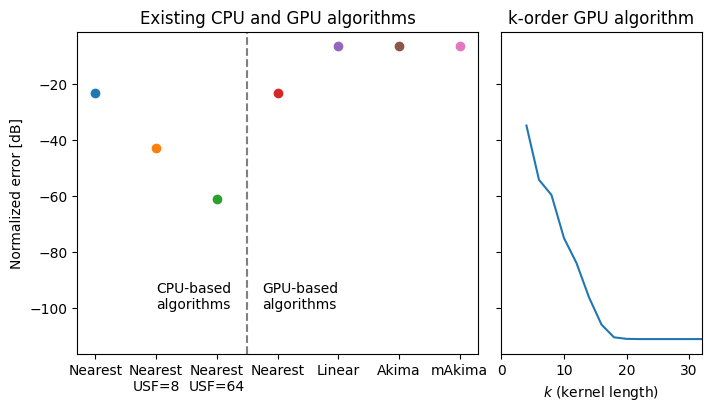

(np.float64(35.48316740429086),
 np.float64(35.48316740429086),
 np.float64(246.1996543436526),
 np.float64(246.19965454650733),
 np.float64(246.199658213788),
 np.float64(0.0014537220613223363))

In [11]:
iaxmin = np.argmin(np.abs(zgrid - 7.5E-3))
iaxmax = np.argmin(np.abs(zgrid - 12.5E-3))
ilatmin = np.argmin(np.abs(xgrid + 2.5E-3))
ilatmax = np.argmin(np.abs(xgrid - 2.5E-3))


rmse_norm    = np.sqrt(np.mean(np.abs(im_cpu[None,iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(1,2)))

rmse_korder  = np.sqrt(np.mean(np.abs(ims_korder[:,iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[None,iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(1,2)))

rmse_nearest = np.sqrt(np.mean(np.abs(im_gpu_nearest[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))
rmse_CPU_nearest = np.sqrt(np.mean(np.abs(im_cpu_nearest[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))
rmse_CPU_nearusf08 = np.sqrt(np.mean(np.abs(im_cpu_nearusf08[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))
rmse_CPU_nearusf64 = np.sqrt(np.mean(np.abs(im_cpu_nearusf64[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))
rmse_linear  = np.sqrt(np.mean(np.abs(im_gpu_linear[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))
rmse_akima   = np.sqrt(np.nanmean(np.abs(im_gpu_akima[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))
rmse_makima   = np.sqrt(np.mean(np.abs(im_gpu_makima[iaxmin:iaxmax,ilatmin:ilatmax] - im_cpu[iaxmin:iaxmax,ilatmin:ilatmax])**2, axis=(0,1)))


fig, axes = plt.subplots(1, 2, sharey=True, width_ratios=[2, 1])
fig.set_size_inches(7,4)
fig.set_constrained_layout(True)
norm = lambda x: 20*np.log10(x/rmse_norm)

ax=axes[0]
ax.scatter(-70, norm(rmse_CPU_nearest))
ax.scatter(-60, norm(rmse_CPU_nearusf08))
ax.scatter(-50, norm(rmse_CPU_nearusf64))
ax.scatter(-40, norm(rmse_nearest))
ax.scatter(-30, norm(rmse_linear))
ax.scatter(-20, norm(rmse_akima))
ax.scatter(-10, norm(rmse_makima))
ax.axvline(-45, color='gray', linestyle='--')
ax.set_ylabel("Normalized error [dB]")
ax.set_xticks([-70, -60, -50, -40, -30, -20, -10], ["Nearest", "Nearest\nUSF=8", "Nearest\nUSF=64", "Nearest", "Linear", "Akima", "mAkima"])
ax.set_title("Existing CPU and GPU algorithms")
ax.text(-60, -100, "CPU-based\nalgorithms")
ax.text(-42.5, -100, "GPU-based\nalgorithms")

ax=axes[1]
ax.plot(ks, norm(rmse_korder))
ax.set_xlabel("$k$ (kernel length)")
ax.set_xlim(0, 32)
ax.set_title("k-order GPU algorithm")
plt.show()

rmse_korder.shape, ks.shape

rmse_CPU_nearest, rmse_nearest, rmse_akima, rmse_makima, rmse_linear, rmse_korder[-1]